# Assessment of self-consumption value for typical household profile with PV generation and battery storage: Influence of the timestep and max battery power

This worksheet computes the self-consumption indicators for different PV and household demand profiles. Historical data is used to evaluate the impact of two parameters:
- the simulation time step
- the battery maximum charging and discharging power

For the sake of openness, the selected format is the open-source Ipython Notebook format, which allows to easily follow and check all calculations and hypotheses. The input data is public data and is also made available through csv files. The original ipynb file can be downloaded and allows further reuse/modification/adaptation of the notebook.

Sylvain Quoilin

Researcher at the European Commission (JRC).

E-mail: sylvain.quoilin@ec.europa.eu - Twitter: @squoilin

NB: The views expressed are purely those of the author and may not in any circumstances be regarded as stating an official position of the European Commission.

February 2015


## Loading Libraries and input data

All libraries are standard libraries that can be downloaded using pip or a package manager.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib
import pickle
import sys
#from SC_functions import *
from time import sleep
%matplotlib inline

### Historical Curve for 30 UK households

In [2]:
[TimeSeries_hist, HouseInfo_hist] = pickle.load(open('pickle/TimeSeries_UK.pickle','rb'))

### Measurements on a French household

In [3]:
[TimeSeries_fr, HouseInfo_fr] = pickle.load(open('pickle/TimeSeries_FR.pickle','rb'))
[TimeSeries_1min, HouseInfo_fr] = pickle.load(open('pickle/TimeSeries_fr_1min.pickle','rb'))
HouseInfo_hist = HouseInfo_hist.append(HouseInfo_fr)
TimeSeries_hist = TimeSeries_hist.join(TimeSeries_fr)

### Measurements on Protugese households

Sustdata, extracted 21 housholds with measurements for one year (2011), 1 min

In [4]:
[TimeSeries_1min_temp, HouseInfo_temp] = pickle.load(open('pickle/TimeSeries_PT_min.pickle','rb'))
HouseInfo_hist = HouseInfo_hist.append(HouseInfo_temp)
TimeSeries_1min_temp.index = TimeSeries_1min.index
TimeSeries_1min = TimeSeries_1min.join(TimeSeries_1min_temp/1000)

### Loading PV data

In [5]:
solar_data = pd.read_excel('data/meteonorm.xls')
idx = []
for key in solar_data.columns:
    idx.append(str(key.strip()))

solar_data.columns = idx

solar_data_15min = pd.DataFrame(columns = solar_data.columns,index=np.arange(35040))
solar_data_1min = pd.DataFrame(columns = solar_data.columns,index=np.arange(35040*15))

for key in solar_data.columns:
    solar_data_15min[key] = pd.Series(data=np.interp(np.linspace(start=0,stop=8760,num=8760*4),range(8760),solar_data[key].values))
    solar_data_1min[key] = pd.Series(data=np.interp(np.linspace(start=0,stop=8760,num=8760*60),range(8760),solar_data[key].values))

solar_data.columns

Index([u'TIME', u'Belgium', u'Germany', u'Italy', u'Spain', u'France', u'UK', u'Austria', u'Denmark', u'Hungary', u'Netherlands', u'Portugal', u'Romania', u'Italy-Palermo', u'Spain-Seville', u'Germany-Munich', u'Greece'], dtype='object')

### Plotting a sample of the data, historical values

Yearly PV generation: 9646.03158333 kWh
Yearly demand: 9646.03158333 kWh
Self Consumption: 3062.33017843 kWh
SSR = 0.317470469796
SCR = 0.317470469796


/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


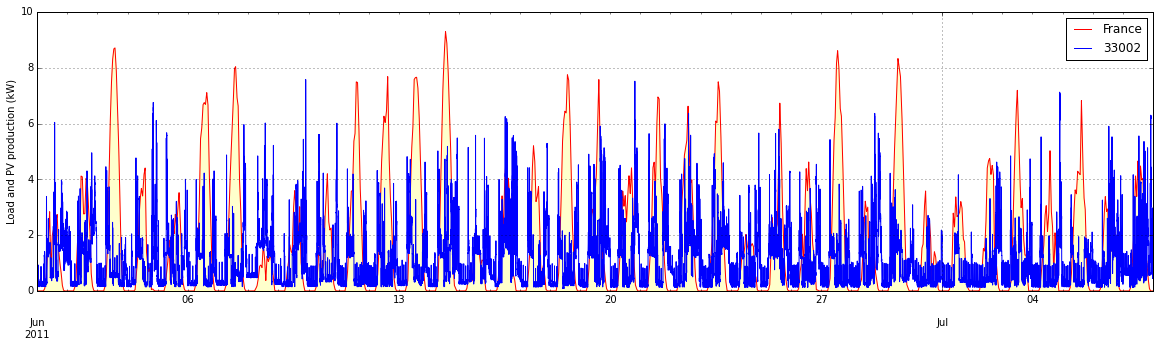

In [6]:
house_id = 33002
start = '06/01/2011 00:00:00'     # start of plotting interval
end = '07/08/2011 00:00:00'       # end of plotting interval
ratio_PV = 1                     # Ratio of yearly PV production to yearly demand

index_2011 = pd.DatetimeIndex(start='01/01/2011 00:00:00',end='31/12/2011 23:59:00',freq='min')
interval = pd.DatetimeIndex(start=start,end=end,freq='min')

demand = TimeSeries_1min[house_id]
demand.index = index_2011

PV = solar_data_1min[unicode(HouseInfo_hist['Country'][house_id])]
PV.index = index_2011

PV = PV * HouseInfo_hist['Annual Consumption'][house_id]/PV.sum()*60 * ratio_PV
demand = demand * HouseInfo_hist['Annual Consumption'][house_id]/demand.sum()*60

plt.figure(figsize=(20,5))
PV[interval].plot(legend=True,color='red')
demand[interval].plot(legend=True,color='blue')
plt.ylabel('Load and PV production (kW)')

plt.fill_between(interval.values,PV[interval],0,color='yellow',alpha='0.2')

self_consumption = np.minimum(PV.values,demand.values).sum()/60
SSR = self_consumption/demand.sum()*60
SCR = self_consumption/PV.sum()*60

print 'Yearly PV generation: ' + str(PV.sum()/60) + ' kWh'
print 'Yearly demand: ' + str(demand.sum()/60) + ' kWh'
print 'Self Consumption: ' + str(self_consumption) + ' kWh'
print 'SSR = ' + str(SSR)
print 'SCR = ' + str(SCR)

### Battery dispatch algorithm

In [7]:
from SC_functions import battery_simulation

ratio_PV = 0    

param = {'BatteryCapacity':17,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':1./60}

PV_DC = PV * HouseInfo_hist['Annual Consumption'][house_id]/PV.sum()*60 * ratio_PV/param['InverterEfficiency']

[BatteryGeneration,BatteryConsumption,LevelOfCharge,EnergyWithGrid] = battery_simulation(PV_DC,demand,param,print_analysis=True)




Total yearly consumption: 9646.03158333 kWh
Total PV production: 0.0 kWh
Self Consumption: 7.53419999999 kWh
Total fed to the grid: 0.0 kWh
Total bought from the grid: 9638.49738333 kWh
Self consumption rate (SCR): inf%
Self sufficiency rate (SSR): 0.0781067316119%
Amount of energy provided by the battery: 7.82 kWh
Average Charging/Discharging depth: 0.0012602739726
Number of equivalent full cycles per year: 0.46
Total battery losses: -7.82 kWh
Total inverter losses: 0.3128 kWh
Residue (check) :-0.0269999999946kWh 



### Influence of the time step

In [8]:
import yearly_simulation   # Importing the compiled version of the battery dispatch algorithm (much faster)
from SC_functions import scale_vector
from __future__ import division


Nminutes = [1,15,60]
ratios_battery = np.arange(0,5,0.5)
#ratios_battery = [0]

SSR_dt = np.zeros([len(Nminutes),len(ratios_battery)])
X = np.zeros([len(Nminutes),len(ratios_battery)])
Y = np.zeros([len(Nminutes),len(ratios_battery)])

param = {'BatteryCapacity':7,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':0.25}
ratio_PV = 1
MaxPower = 100

for i in range(len(Nminutes)):
    dt = Nminutes[i]
    PV_scaled = scale_vector(PV.values,int(8760*60/dt))
    demand_scaled = scale_vector(demand.values,int(8760*60/dt))
    N = len(PV_scaled)
    PVsum = PV_scaled.sum()/(N/8760)
    DemandSum = demand_scaled.sum()/(N/8760)  

    for j in range(len(ratios_battery)):
        ratio_battery = ratios_battery[j]
        param['BatteryCapacity'] = ratio_battery * DemandSum / 1000
        param['timestep'] = dt/60
        PV_DC = PV_scaled * HouseInfo_hist['Annual Consumption'][house_id]/PVsum * ratio_PV
        SSR_dt[i,j] = yearly_simulation.yearly_simulation_v2(PV_DC,demand_scaled,param['timestep'],param['BatteryCapacity'], param['BatteryEfficiency'],MaxPower, param['InverterEfficiency'])
        #SSR_hist[i,j] = battery_simulation(PV_DC,demand_scaled,param,print_analysis=False,output_timeseries=False)
        X[i,j] = dt
        Y[i,j] = param['BatteryCapacity']
        sys.stdout.write('.')

Target size is iqual to input vector size. Not doing anything
Target size is iqual to input vector size. Not doing anything
..........Target size is entire divisor of the input vector size. Averaging
Target size is entire divisor of the input vector size. Averaging
..........Target size is entire divisor of the input vector size. Averaging
Target size is entire divisor of the input vector size. Averaging
..........

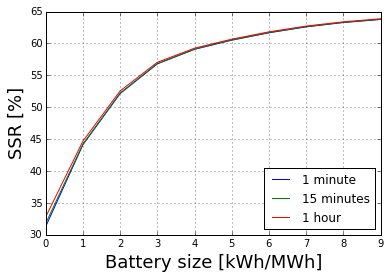

In [9]:
pd.DataFrame(SSR_dt)

df = pd.DataFrame(SSR_dt).transpose()
df.columns= ['1 minute', '15 minutes', '1 hour']

ax = df.plot()

ax.set_xlabel("Battery size [kWh/MWh]")
ax.xaxis.label.set_fontsize(18)
ax.set_ylabel('SSR [%]')
ax.yaxis.label.set_fontsize(18)


In [10]:
pd.DataFrame(SSR_dt)

,0,1,2,3,4,5,6,7,8,9
0,31.314755,44.140563,52.153108,56.802613,59.088041,60.516304,61.678158,62.604816,63.286001,63.767015
1,31.814023,44.242615,52.235826,56.853953,59.127352,60.554039,61.712678,62.635436,63.313616,63.794211
2,32.817979,44.707169,52.569238,57.056430,59.266569,60.679553,61.826015,62.734733,63.398790,63.875539


### Influence of the maximum battery power

In [11]:
import yearly_simulation   # Importing the compiled version of the battery dispatch algorithm (much faster)
from SC_functions import scale_vector
from __future__ import division


Powers = [1,2,3,4,5]
ratios_battery = np.arange(0,5,0.5)

SSR_maxpower = np.zeros([len(Powers),len(ratios_battery)])
X = np.zeros([len(Powers),len(ratios_battery)])
Y = np.zeros([len(Powers),len(ratios_battery)])

param = {'BatteryCapacity':7,'BatteryEfficiency':0.92,'InverterEfficiency':0.96,'timestep':0.25}
ratio_PV = 1
dt = 1
PV_scaled = scale_vector(PV.values,int(8760*60/dt))
demand_scaled = scale_vector(demand.values,int(8760*60/dt))
N = len(PV_scaled)
PVsum = PV_scaled.sum()/(N/8760)
DemandSum = demand_scaled.sum()/(N/8760)  
for i in range(len(Powers)):
    MaxPower = Powers[i]
    for j in range(len(ratios_battery)):
        ratio_battery = ratios_battery[j]
        param['BatteryCapacity'] = ratio_battery * DemandSum / 1000
        param['timestep'] = dt/60
        PV_DC = PV_scaled * HouseInfo_hist['Annual Consumption'][house_id]/PVsum * ratio_PV
        SSR_maxpower[i,j] = yearly_simulation.yearly_simulation_v2(PV_DC,demand_scaled,param['timestep'],param['BatteryCapacity'], param['BatteryEfficiency'],MaxPower, param['InverterEfficiency'])
        #SSR_hist[i,j] = battery_simulation(PV_DC,demand,param,print_analysis=False,output_timeseries=False)
        X[i,j] = dt
        Y[i,j] = param['BatteryCapacity']
        sys.stdout.write('.')

Target size is iqual to input vector size. Not doing anything
Target size is iqual to input vector size. Not doing anything
..................................................

,0,1,2,3,4,5,6,7,8,9
0,31.314755,43.458203,47.500327,48.128972,48.465364,48.578020,48.664565,48.730805,48.797045,48.863285
1,31.314755,44.076232,51.438191,54.505375,55.598977,56.311505,56.718032,56.949285,57.103845,57.258405
2,31.314755,44.135620,52.047738,56.298206,58.119780,59.258550,60.116838,60.668146,61.015373,61.258253
3,31.314755,44.140479,52.143705,56.685331,58.865241,60.178584,61.254504,62.046224,62.569575,62.890320
4,31.314755,44.140563,52.152795,56.778621,59.041061,60.449731,61.585370,62.467546,63.105166,63.519974


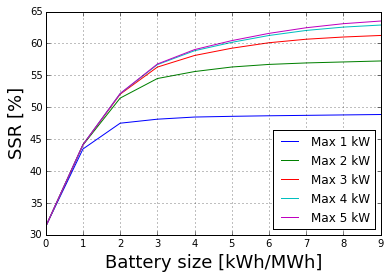

In [14]:
%matplotlib inline

df = pd.DataFrame(SSR_maxpower).transpose()
df.columns=['Max ' + str(i) + ' kW' for i in Powers]

ax = df.plot()

ax.set_xlabel("Battery size [kWh/MWh]")
ax.xaxis.label.set_fontsize(18)
ax.set_ylabel('SSR [%]')
ax.yaxis.label.set_fontsize(18)

pd.DataFrame(SSR_maxpower)